0.23675014636543995 0.30137824566882276


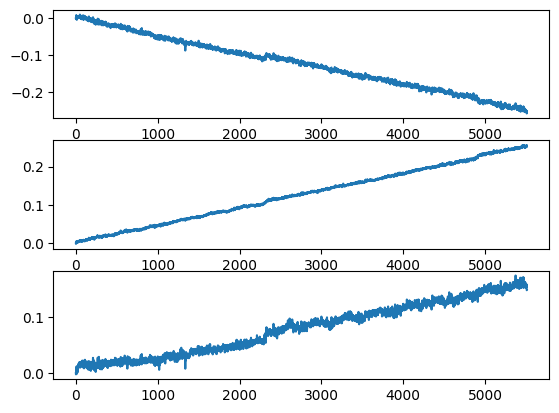

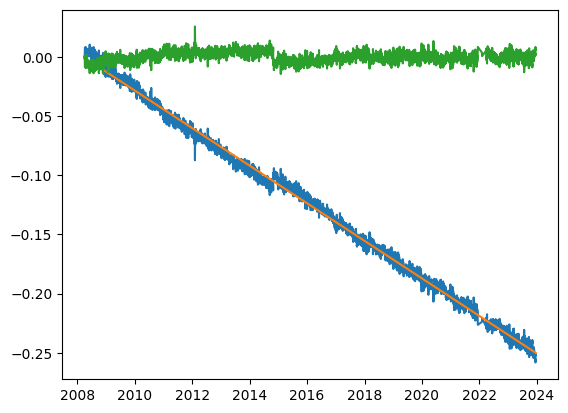

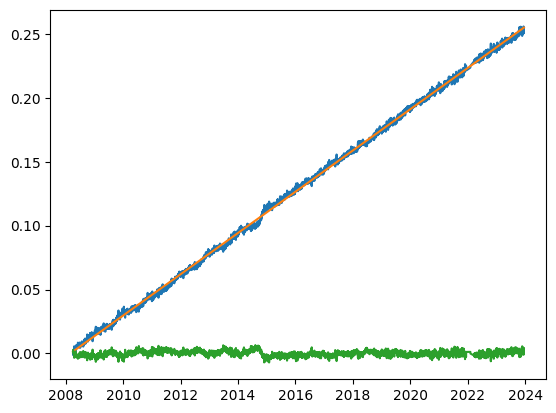

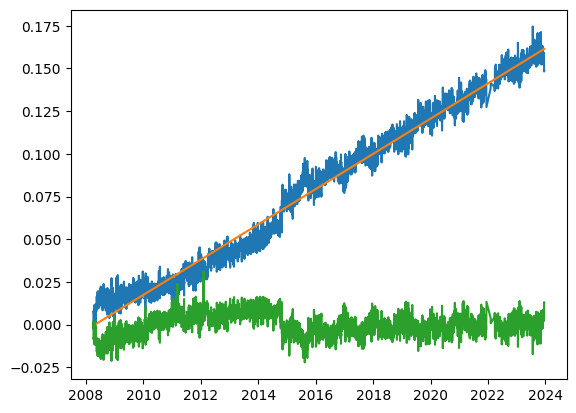

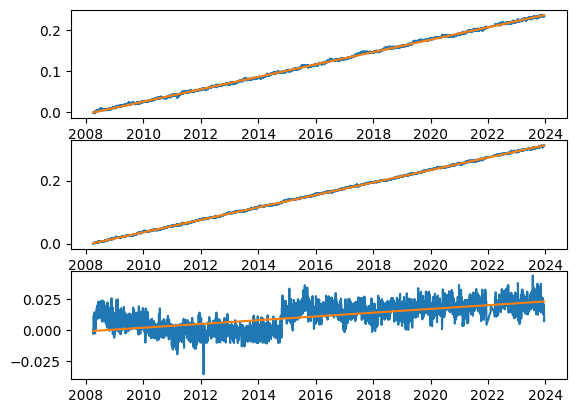

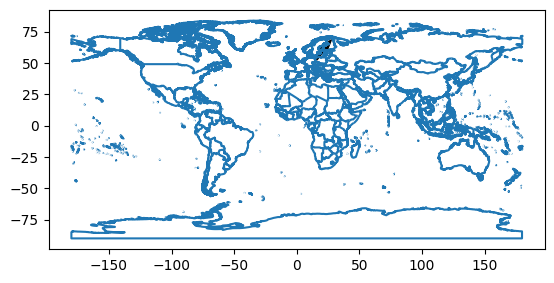

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import geopandas as gpd

dane = np.genfromtxt('GWWL.txyz2.txt')
t = dane[:, 2]
xyz = dane[:, 3:6]
dxyz = xyz - xyz[0, :]

#wykres różnic współrzędnych
fig, ax = plt.subplots(3, 1)
ax[0].plot(dxyz[:,0])
ax[1].plot(dxyz[:,1])
ax[2].plot(dxyz[:,2])

#Regresja liniowa dl akażdej wspolrzednej
# dla wspolrzednej x
x = dxyz[:,0]
jedynki = np.ones(len(t))
A = np.column_stack((t, jedynki))
L = x
xx = np.linalg.inv(A.T@A)@(A.T@L)
model = A@xx
v = model - L

fig1, ax = plt.subplots()
ax.plot(t, dxyz[:,0])
ax.plot(t, model)
ax.plot(t, v)

# dla wspolrzednej y
y = dxyz[:,1]
jedynki1 = np.ones(len(t))
A1 = np.column_stack((t, jedynki1))
L1 = y
yy = np.linalg.inv(A1.T@A1)@(A1.T@L1)
model1 = A1@yy
v1 = model1 - L1

fig2, ax = plt.subplots()
ax.plot(t, dxyz[:,1])
ax.plot(t, model1)
ax.plot(t, v1)

# dla wspolrzednej z
z = dxyz[:,2]
jedynki2 = np.ones(len(t))
A2 = np.column_stack((t, jedynki2))
L2 = z
zz = np.linalg.inv(A2.T@A2)@(A2.T@L2)
model2 = A2@zz
v2 = model2 - L2

fig3, ax = plt.subplots()
ax.plot(t, dxyz[:,2])
ax.plot(t, model2)
ax.plot(t, v2)

e2 = 0.00669438002290
a = 6378137

def Np(B, a=a, e2=e2):
    N = a/(1-e2*(np.sin(B)**2))**0.5
    return N

def hirv(x,y,z):
    p = np.sqrt(x**2+y**2)

    phi = np.arctan(z/(p*(1-e2)))
    
    while True:
        N = Np(phi)
        h = p/np.cos(phi) - N
        phi_poprzednie = phi
        phi = np.arctan((z/p) * (1-(N*e2)/(N+h))**(-1))
        if abs(phi_poprzednie-phi)<(0.000001/60/60/360):
            break
    lam = np.arctan2(y,x)
    return phi, lam, h

phi, lam, h = hirv(xyz[0, 0], xyz[0, 1], xyz[0, 2])

Rneu = np.array([[-np.sin(phi)*np.cos(lam), -np.sin(lam), np.cos(phi) * np.cos(lam)], #uzupelnic tak jak w instrukcji 
                        [-np.sin(phi) * np.sin(lam), np.cos(lam), np.cos(phi) * np.sin(lam)],
                        [np.cos(phi), 0, np.sin(phi)]])

#Transformacja różnic współrzędnych do układu NEU:
dneu = []
for dx in dxyz:
    dneu.append(Rneu.T@dx)
dneu = np.array(dneu)

#Regresja liniowa dla każdej współrzędnej w układzie NEU:
y_linia_lista = []
for i in range(3):
    y = dneu[:, i]
    xx = np.linalg.inv(A.T@A)@(A.T@y)
    y_linia = A@xx
    y_linia_lista.append(y_linia)
y_linia_lista = np.array(y_linia_lista).T
# y_model = y_linia_lista
y_model = np.array(y_linia_lista)

#Wykresy różnic współrzędnych w układzie NEU:
fig, ax = plt.subplots(3, 1)
for i in range(len(ax)):
    ax[i].plot(t, dneu[:, i])
    ax[i].plot(t, y_linia_lista[:, i])

#Wyswietlanie mapy i strzałki
filee = 'C:/Users\micha\OneDrive\Pulpit\Studia GI\Studia GI 3\Wybrane Zagadnienia z Geodezji Wyższej\p_6\CNTR_BN_03M_2020_4326.shp'
shpfile = gpd.read_file(filee)
fig, ax = plt.subplots()
shpfile.plot(ax=ax)
vn = y_model[-1,0] - y_model[0,0]/(t[-1]-t[0])*100
ve = y_model[-1,1] - y_model[0,1]/(t[-1]-t[0])*100
print(vn, ve)
Q = ax.quiver(np.rad2deg(lam), np.rad2deg(phi), vn, ve)
ax.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{cm}{year}$', labelpos='E', coordinates='figure', zorder = 2)

plt.show()